In [1]:
import numpy as np
import random
import torch
from gpytorch.kernels import ScaleKernel, RBFKernel
from linear_operator.operators import KroneckerProductLinearOperator
from torch import Tensor
from torch.distributions import MultivariateNormal
from lvmogp_svi import LVMOGP_SVI
from gaussian_likelihood import GaussianLikelihood
from variational_elbo import VariationalELBO
from tqdm import trange
from torch.optim.lr_scheduler import StepLR
from util_functions import *
import gpytorch

In [2]:
expri_random_seed = 5

In [3]:
# load in synthetic data (only call this function once)
idgp_n_C_total = 700 # totally 700 points for C
idgp_n_outputs = 20
idgp_X_true, idgp_C_total, idgp_sample_total_data, kernel_parameters = tidily_sythetic_data_from_MOGP(n_C=idgp_n_C_total, n_X=idgp_n_outputs, random_seed=expri_random_seed)
# sample_total_data: of length n_outputs * n_C_total.

idgp_n_C_train = 50
idgp_n_C_test = idgp_n_C_total - idgp_n_C_train

random.seed(expri_random_seed)
idgp_train_C_tidily_indices = random.sample(range(idgp_n_C_total), idgp_n_C_train) # of length n_C_train
idgp_test_C_tidily_indices = [index for index in range(idgp_n_C_total) if index not in idgp_train_C_tidily_indices] # of length n_C_test

# list (n_outputs) of list (n_C_train), 
idgp_ls_of_ls_train_C = [idgp_train_C_tidily_indices for _ in range(idgp_n_outputs)]

In [4]:
idgp_sample_train_index = idgp_train_C_tidily_indices
for i in range(1, idgp_n_outputs): # 20 outputs, except the first one is already included
    idgp_sample_train_index = np.concatenate((idgp_sample_train_index, list(np.array(idgp_train_C_tidily_indices) + idgp_n_C_total*i)))

idgp_sample_test_index = idgp_test_C_tidily_indices
for i in range(1, idgp_n_outputs): # 20 outputs, except the first one is already included
    idgp_sample_test_index = np.concatenate((idgp_sample_test_index, list(np.array(idgp_test_C_tidily_indices) + idgp_n_C_total*i)))

assert idgp_sample_train_index.shape[0] == idgp_n_C_train * idgp_n_outputs
assert idgp_sample_test_index.shape[0] == idgp_n_C_test* idgp_n_outputs
assert np.isin(idgp_sample_train_index, idgp_sample_test_index).sum() == 0

idgp_sample_train_data = idgp_sample_total_data[idgp_sample_train_index]
idgp_sample_test_data = idgp_sample_total_data[idgp_sample_test_index]

In [5]:
list_idgp_function_index = [i for i in range(idgp_n_outputs)]
list_train_X, list_train_Y = [], [] # list_train_X contains all same elements.
list_test_X, list_test_Y = [], []
list_total_X, list_total_Y = [], [] # list_total_X contains all same elements.

for idgp_function_index in list_idgp_function_index:
    # Data
    idgp_train_start = idgp_function_index * idgp_n_C_train
    idgp_train_end = idgp_train_start + idgp_n_C_train

    idgp_test_start = idgp_function_index * idgp_n_C_test
    idgp_test_end = idgp_test_start + idgp_n_C_test

    idgp_total_start = idgp_function_index * idgp_n_C_total
    idgp_total_end = idgp_total_start + idgp_n_C_total

    # training data
    train_X = idgp_C_total[idgp_train_C_tidily_indices]
    train_Y = idgp_sample_train_data[idgp_train_start:idgp_train_end]
    assert train_X.shape ==  train_Y.shape == torch.Size([idgp_n_C_train])
    list_train_X.append(train_X)
    list_train_Y.append(train_Y)

    # testing data
    test_X = idgp_C_total[idgp_test_C_tidily_indices]
    test_Y = idgp_sample_test_data[idgp_test_start:idgp_test_end]
    assert test_X.shape == test_Y.shape == torch.Size([idgp_n_C_test])
    list_test_X.append(test_X)
    list_test_Y.append(test_Y)

    # total data, of length idgp_n_C_total
    total_X = idgp_C_total
    total_Y = idgp_sample_total_data[idgp_total_start:idgp_total_end]
    assert total_X.shape == total_Y.shape == torch.Size([idgp_n_C_total])
    list_total_X.append(total_X)
    list_total_Y.append(total_Y)

In [6]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

# Model
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [7]:
# Hyperparameters
idgp_n_inducing_C = 15
learning_rate = 0.01

#### Train 20 gps one by one

In [8]:
from gaussian_likelihood import GaussianLikelihood
from variational_elbo import VariationalELBO

list_models = []
list_likelihoods = []
list_idgp_loss_list = []

for j in range(idgp_n_outputs):

    train_X = list_train_X[j]
    train_Y = list_train_Y[j]
    
    inducing_points = torch.rand(idgp_n_inducing_C).reshape(-1,1) * 20 - 10
    model = GPModel(inducing_points=inducing_points)
    likelihood = GaussianLikelihood()

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=learning_rate)

    wo_scheduler = StepLR(optimizer, step_size=50, gamma=0.95)  # 0.3, 50, 0.95; 

    # Our loss object. We're using the VariationalELBO
    mll = VariationalELBO(likelihood, model, num_data=train_Y.size(0))

    # have a look at parameters
    # for name, param in model.named_parameters():
    #    print(name, param.size())
        
    # start training!
    idgp_loss_list = []
    n_iterations = 2500 # 1500 # 10000
    iterator = trange(n_iterations, leave=True)
    idgp_model_max_grad_norm = 15
    idgp_likeli_max_grad_norm = 0.7

    for i in iterator:
        optimizer.zero_grad()
        output_pred = model(train_X)
        loss = -mll(output_pred, train_Y)
        idgp_loss_list.append(loss.item())
        iterator.set_description( 'Training '+ str(j) + 'th Model; '+ 'Loss: ' + str(float(np.round(loss.item(),3))) + ", iter no: " + str(i))
        loss.backward()

        # clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), idgp_model_max_grad_norm)
        torch.nn.utils.clip_grad_norm_(likelihood.parameters(), idgp_likeli_max_grad_norm)

        optimizer.step()
        wo_scheduler.step()

    # After traininhg, store all the models ... 
    list_models.append(model)
    list_likelihoods.append(likelihood)
    list_idgp_loss_list.append(idgp_loss_list)

Training 19th Model; Loss: 0.354, iter no: 2499: 100%|██████████| 2500/2500 [00:28<00:00, 86.95it/s] 


#### Get 20 gp testing results one by one

In [9]:
list_idgp_train_output_dist = []
list_idgp_test_output_dist = []
list_idgp_total_output_dist = []

train_error_square_sum = 0
test_error_square_sum = 0

train_error_length = 0
test_error_length = 0

for j in range(idgp_n_outputs):
    curr_model = list_models[j]
    curr_likelihood = list_likelihoods[j]

    curr_train_X = list_train_X[j]
    curr_train_Y = list_train_Y[j]

    curr_test_X = list_test_X[j]
    curr_test_Y = list_test_Y[j]

    curr_total_X = list_total_X[j]
    curr_total_Y = list_total_Y[j]

    idgp_train_output_dist = curr_likelihood(curr_model(curr_train_X))
    idgp_test_output_dist  = curr_likelihood(curr_model(curr_test_X))
    idgp_total_output_dist = curr_likelihood(curr_model(curr_total_X))

    train_error_square_sum += (idgp_train_output_dist.loc.detach() - curr_train_Y).square().sum()
    print(str(j) + 'th Model Train RMSE: ', (idgp_train_output_dist.loc.detach() - curr_train_Y).square().mean().sqrt())
    test_error_square_sum += (idgp_test_output_dist.loc.detach() - curr_test_Y).square().sum()
    print(str(j) + 'th Model Test RMSE: ', (idgp_test_output_dist.loc.detach() - curr_test_Y).square().mean().sqrt())

    train_error_length += idgp_train_output_dist.loc.detach().shape[0]
    test_error_length += idgp_test_output_dist.loc.detach().shape[0]    

    list_idgp_train_output_dist.append(idgp_train_output_dist)
    list_idgp_test_output_dist.append(idgp_test_output_dist)
    list_idgp_total_output_dist.append(idgp_total_output_dist)


print('Global Train RMSE', (train_error_square_sum / train_error_length).sqrt())
print('Global Test RMSE', (test_error_square_sum / test_error_length).sqrt())


0th Model Train RMSE:  tensor(0.1955)
0th Model Test RMSE:  tensor(0.3180)
1th Model Train RMSE:  tensor(0.2212)
1th Model Test RMSE:  tensor(0.3496)
2th Model Train RMSE:  tensor(0.3711)
2th Model Test RMSE:  tensor(0.5539)
3th Model Train RMSE:  tensor(0.2727)
3th Model Test RMSE:  tensor(0.3606)
4th Model Train RMSE:  tensor(0.2435)
4th Model Test RMSE:  tensor(0.3528)
5th Model Train RMSE:  tensor(0.2477)
5th Model Test RMSE:  tensor(0.4018)
6th Model Train RMSE:  tensor(0.2705)
6th Model Test RMSE:  tensor(0.3621)
7th Model Train RMSE:  tensor(0.2770)
7th Model Test RMSE:  tensor(0.3616)
8th Model Train RMSE:  tensor(0.1818)
8th Model Test RMSE:  tensor(0.3070)
9th Model Train RMSE:  tensor(0.2411)
9th Model Test RMSE:  tensor(0.2976)
10th Model Train RMSE:  tensor(0.2050)
10th Model Test RMSE:  tensor(0.3099)
11th Model Train RMSE:  tensor(0.2581)
11th Model Test RMSE:  tensor(0.3946)
12th Model Train RMSE:  tensor(0.2815)
12th Model Test RMSE:  tensor(0.4096)
13th Model Train RM

#### select one output, and plot

In [10]:
selected_output_index = 18

selected_model = list_models[selected_output_index]
selected_train_X = list_train_X[selected_output_index]
selected_train_Y = list_train_Y[selected_output_index]
selected_test_X = list_test_X[selected_output_index]
selected_test_Y = list_test_Y[selected_output_index]
selected_gp_X = list_total_X[selected_output_index]
selected_gp_pred_mean = list_idgp_total_output_dist[selected_output_index].loc.detach()
selected_gp_pred_std = list_idgp_total_output_dist[selected_output_index].stddev.detach()

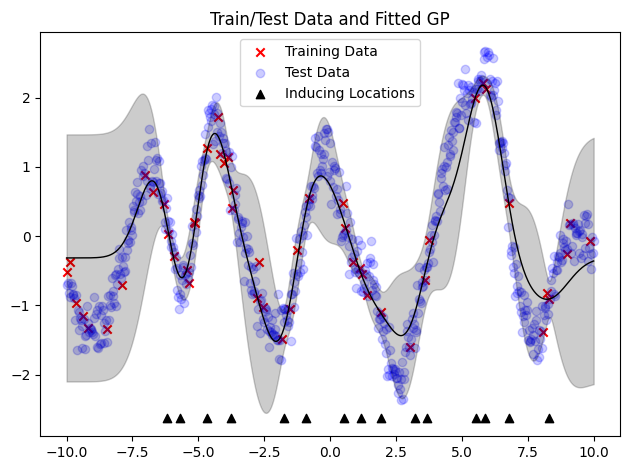

In [11]:
plot_traindata_testdata_fittedgp(train_X=selected_train_X, train_Y=selected_train_Y, test_X=selected_test_X, test_Y=selected_test_Y, gp_X=selected_gp_X, gp_pred_mean=selected_gp_pred_mean, gp_pred_std=selected_gp_pred_std, inducing_points_X=selected_model.variational_strategy.inducing_points.detach(), n_inducing_C=idgp_n_inducing_C) # NOTE: input is C not X